<a href="https://colab.research.google.com/github/divyanshuraj6815/EVA6/blob/main/Experiment_9/experiment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

!pip install albumentations==0.4.6

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
!rm -r EVA6
!git clone https://github.com/divyanshuraj6815/EVA6.git

Cloning into 'EVA6'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (190/190), done.
remote: Total 200 (delta 84), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (200/200), 2.30 MiB | 10.94 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [5]:
from EVA6.Experiment_9.model import ResNet
from EVA6.Experiment_9.get_mean_and_std import get_mean_std
from EVA6.Experiment_9.train_test_module import train, test

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

get_mean_std (trainloader)

Files already downloaded and verified


(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]), 98)

In [7]:
import cv2
train_transform = A.Compose ([
    A.PadIfNeeded (min_height = 40, min_width = 40, border_mode = cv2.BORDER_CONSTANT, value = (0.4914, 0.4822, 0.4465)),
    A.HorizontalFlip (),
    A.CoarseDropout (max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=(0.4914, 0.4822, 0.4465), p=0.8),
    A.ShiftScaleRotate (shift_limit = 0.05, scale_limit = 0.1, rotate_limit = 9, p = 0.5),
    A.RandomCrop (height = 32, width = 32, always_apply = True),
    A.Normalize (mean = (0.4914, 0.4822, 0.4465), std = (0.2470, 0.2435, 0.2616)),
    ToTensorV2()
])

test_transform = A.Compose ([
    A.Normalize (mean = (0.4914, 0.4822, 0.4465), std = (0.2470, 0.2435, 0.2616)),
    ToTensorV2()
])

In [8]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [9]:
trainset = Cifar10SearchDataset(train = True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)

testset = Cifar10SearchDataset(train = False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                          shuffle=True, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

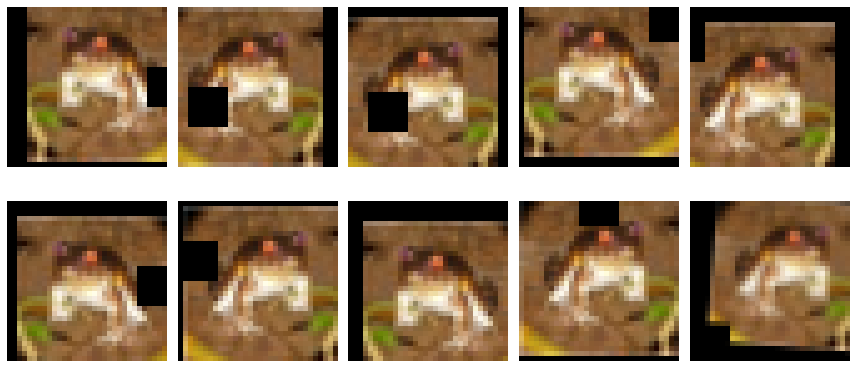

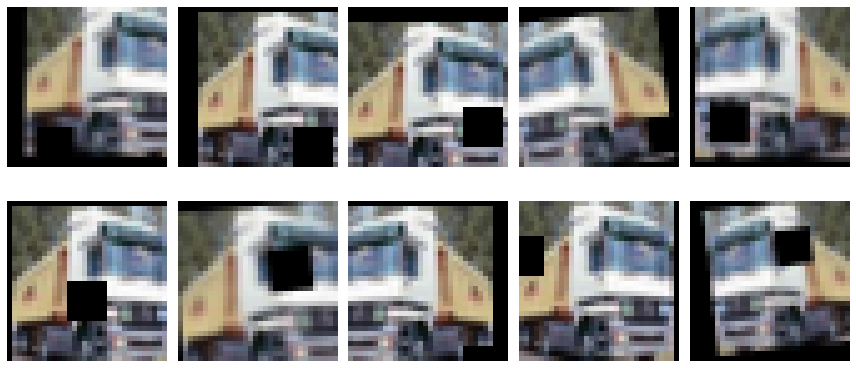

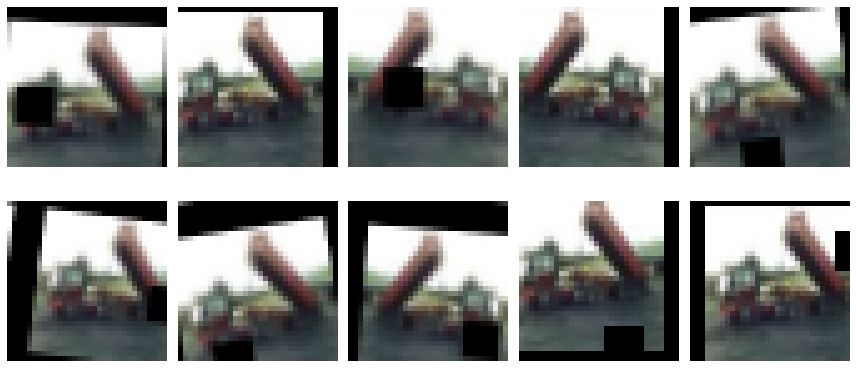

In [11]:
random.seed(40)
visualize_augmentations(trainset, idx = 0)
visualize_augmentations(trainset, idx = 1)
visualize_augmentations(trainset, idx = 2)

In [13]:
!pip install torchsummary
import torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
           Dropout-3           [-1, 64, 32, 32]               0
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
           Dropout-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
          Dropout-12          [-1, 128, 16, 16]               0
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [14]:
!pip install torch-lr-finder

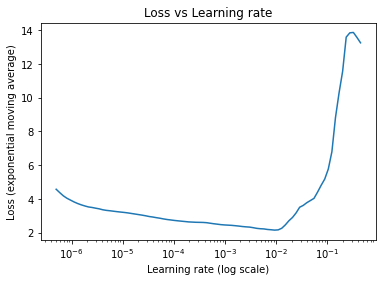

In [ ]:
from pytorch_lr_finder import LearningRateFinder
model =  ResNet()
criterion = nn.CrossEntropyLoss ()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

lrf = LearningRateFinder(model, criterion, optimizer)
lrf.fit(trainloader)
lrf.plot()

In [ ]:
lrf.loss_history

{1e-07: 3.15999436378479,
 1.1748975549395294e-07: 3.0921947956085205,
 1.3803842646028847e-07: 3.195965528488159,
 1.6218100973589298e-07: 3.2003285884857178,
 1.905460717963247e-07: 3.2111082077026367,
 2.2387211385683393e-07: 3.1522436141967773,
 2.6302679918953816e-07: 3.2862398624420166,
 3.0902954325135903e-07: 3.136000633239746,
 3.630780547701013e-07: 3.0251495838165283,
 4.265795188015926e-07: 3.1192426681518555,
 5.011872336272722e-07: 3.0496795177459717,
 5.888436553555888e-07: 3.1330268383026123,
 6.918309709189363e-07: 3.0078647136688232,
 8.12830516164099e-07: 3.081907033920288,
 9.549925860214356e-07: 3.153341054916382,
 1.122018454301963e-06: 3.049943685531616,
 1.3182567385564065e-06: 3.0565407276153564,
 1.5488166189124807e-06: 3.0641727447509766,
 1.8197008586099826e-06: 3.0816650390625,
 2.137962089502231e-06: 3.071176767349243,
 2.511886431509579e-06: 3.226621627807617,
 2.951209226666384e-06: 3.110548496246338,
 3.4673685045253143e-06: 3.09739089012146,
 4.0738027

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

model =  ResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay = 5e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr = 0.04, 
    epochs = 24, 
    steps_per_epoch = 98,
    pct_start = 0.15, 
    anneal_strategy = 'linear'
)

EPOCHS = 24
count = 0
flag = 1
train_losses = []
train_accs = []
test_losses = []
test_accs = []
learning_rate = []

for epoch in range(EPOCHS):
    print("EPOCH:", epoch, scheduler.get_lr ())
    learning_rate.append (scheduler.get_lr ())
    (train_loss, train_acc) = train(model, device, trainloader, optimizer, epoch, scheduler)
    train_losses += train_loss
    train_accs += train_acc

    (test_loss, test_acc) = test(model, device, testloader)
    test_losses += test_loss
    test_accs += test_acc
learning_rate.append (scheduler.get_lr ())

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:1290: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 0 [0.0016]


Loss=1.7812849283218384 Batch_id=97 Accuracy=30.46: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4767/10000 (47.67%)

EPOCH: 1 [0.012296986924388858]


Loss=1.382383108139038 Batch_id=97 Accuracy=47.94: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 5872/10000 (58.72%)

EPOCH: 2 [0.022993973848777716]


Loss=1.160396695137024 Batch_id=97 Accuracy=56.91: 100%|██████████| 98/98 [01:43<00:00,  1.05s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 6496/10000 (64.96%)

EPOCH: 3 [0.03369096077316657]


Loss=0.8195021748542786 Batch_id=97 Accuracy=64.79: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7463/10000 (74.63%)

EPOCH: 4 [0.03919568148859544]


Loss=1.0304464101791382 Batch_id=97 Accuracy=71.81: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7764/10000 (77.64%)

EPOCH: 5 [0.037234905018007206]


Loss=0.5649097561836243 Batch_id=97 Accuracy=75.41: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7917/10000 (79.17%)

EPOCH: 6 [0.035274128547418966]


Loss=0.6163529753684998 Batch_id=97 Accuracy=77.93: 100%|██████████| 98/98 [01:42<00:00,  1.05s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8251/10000 (82.51%)

EPOCH: 7 [0.033313352076830734]


Loss=0.7457054853439331 Batch_id=97 Accuracy=79.55: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 8031/10000 (80.31%)

EPOCH: 8 [0.031352575606242494]


Loss=0.5147960186004639 Batch_id=97 Accuracy=81.45: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0010, Accuracy: 8373/10000 (83.73%)

EPOCH: 9 [0.029391799135654262]


Loss=0.5842500925064087 Batch_id=97 Accuracy=83.11: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8492/10000 (84.92%)

EPOCH: 10 [0.027431022665066026]


Loss=0.4480818808078766 Batch_id=97 Accuracy=84.19: 100%|██████████| 98/98 [01:42<00:00,  1.05s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8577/10000 (85.77%)

EPOCH: 11 [0.02547024619447779]


Loss=0.4526810050010681 Batch_id=97 Accuracy=85.46: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8645/10000 (86.45%)

EPOCH: 12 [0.023509469723889554]


Loss=0.4092150628566742 Batch_id=97 Accuracy=86.11: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8760/10000 (87.60%)

EPOCH: 13 [0.02154869325330132]


Loss=0.5435015559196472 Batch_id=97 Accuracy=87.06: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8677/10000 (86.77%)

EPOCH: 14 [0.019587916782713086]


Loss=0.360243558883667 Batch_id=97 Accuracy=87.57: 100%|██████████| 98/98 [01:43<00:00,  1.05s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8787/10000 (87.87%)

EPOCH: 15 [0.01762714031212485]


Loss=0.3605390191078186 Batch_id=97 Accuracy=88.56: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8871/10000 (88.71%)

EPOCH: 16 [0.015666363841536614]


Loss=0.3247249126434326 Batch_id=97 Accuracy=88.87: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8938/10000 (89.38%)

EPOCH: 17 [0.013705587370948378]


Loss=0.28539252281188965 Batch_id=97 Accuracy=90.06: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8862/10000 (88.62%)

EPOCH: 18 [0.011744810900360145]


Loss=0.2871096432209015 Batch_id=97 Accuracy=90.50: 100%|██████████| 98/98 [01:43<00:00,  1.05s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8900/10000 (89.00%)

EPOCH: 19 [0.009784034429771906]


Loss=0.2530129849910736 Batch_id=97 Accuracy=91.21: 100%|██████████| 98/98 [01:46<00:00,  1.08s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 8990/10000 (89.90%)

EPOCH: 20 [0.007823257959183677]


Loss=0.23774349689483643 Batch_id=97 Accuracy=91.96: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9040/10000 (90.40%)

EPOCH: 21 [0.005862481488595438]


Loss=0.26606518030166626 Batch_id=97 Accuracy=92.66: 100%|██████████| 98/98 [01:42<00:00,  1.04s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9111/10000 (91.11%)

EPOCH: 22 [0.0039017050180071983]


Loss=0.20857861638069153 Batch_id=97 Accuracy=93.30: 100%|██████████| 98/98 [01:43<00:00,  1.05s/it]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, Accuracy: 9104/10000 (91.04%)

EPOCH: 23 [0.0019409285474189658]


Loss=0.2540911138057709 Batch_id=97 Accuracy=93.98: 100%|██████████| 98/98 [01:45<00:00,  1.08s/it]



Test set: Average loss: 0.0006, Accuracy: 9123/10000 (91.23%)



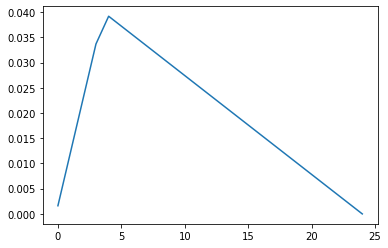

In [16]:
plt.plot (learning_rate)

Text(0.5, 1.0, 'Test Accuracy')

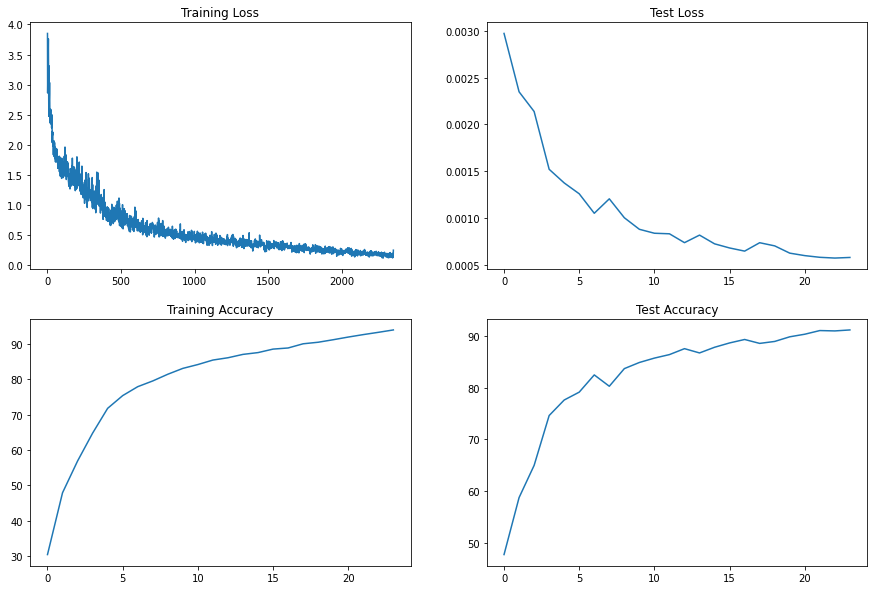

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")

In [18]:
!sudo pip3 install grad-cam
!sudo pip3 install ttach

In [26]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

target_layer = model.layer_3_r[-1]
for images, labels in testloader:
  images = images
  labels = labels 
  break

input_tensor = images
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layer=target_layer, use_cuda=True)

target_category = None

grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category, aug_smooth=True, eigen_smooth=True)
print (input_tensor.shape, grayscale_cam.shape)

torch.Size([512, 3, 32, 32]) (512, 32, 32)


In [27]:
correct = []
wrong = []
model = model.to(device)

img = images
# Turn off gradients to speed up this part
with torch.no_grad():
  logps = model (img.cuda())

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp (logps)
probabs = []
for j, element in enumerate (ps):
  pred = torch.argmax(element)
  if pred == labels[j].item ():
    correct.append ([img[j], ps[j], pred, labels[j].item (), grayscale_cam[j]])
  else:
    wrong.append ([img[j], ps[j], pred, labels[j].item (), grayscale_cam[j]])

len (correct), len (wrong)

(468, 44)

In [28]:
import numpy as np
def view_classify(img, ps, mask):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()
    img = img.permute(1,2,0)
    fig, (ax1, ax4, ax3, ax2) = plt.subplots(figsize=(9,12), ncols=4)
    ax1.imshow(img) #(height,width,dim)
    ax1.axis('off')
    ax4.imshow (mask)
    ax4.axis('off')
    img[mask<=0.4] = 0
    
    img[:,:,0][mask<=0.3] = 1
    img[:,:,1][mask<=0.3] = 0
    img[:,:,2][mask<=0.3] = 0

    img[:,:,0][mask<=0.1] = 1
    img[:,:,1][mask<=0.1] = 1
    img[:,:,2][mask<=0.1] = 0

    ax3.imshow (img)
    ax3.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

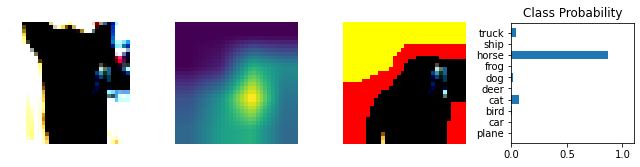

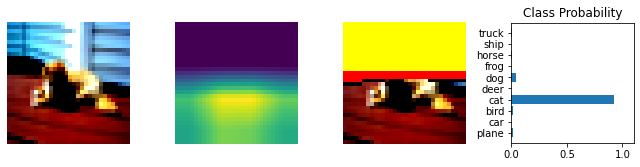

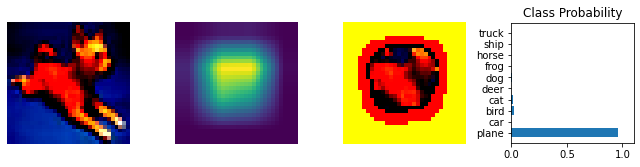

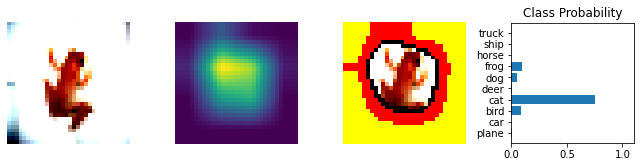

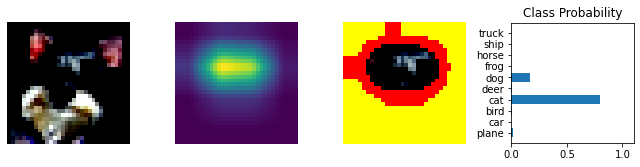

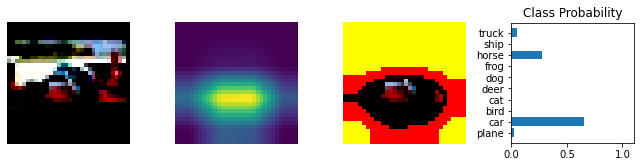

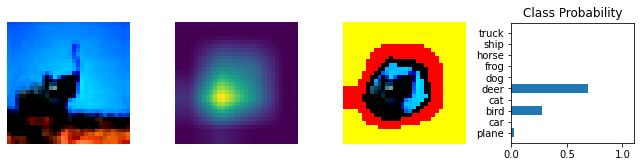

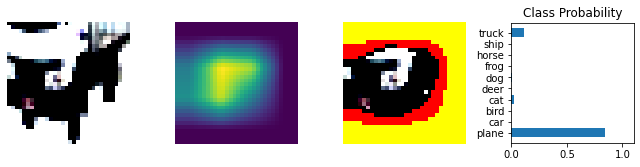

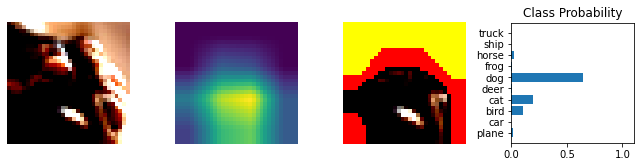

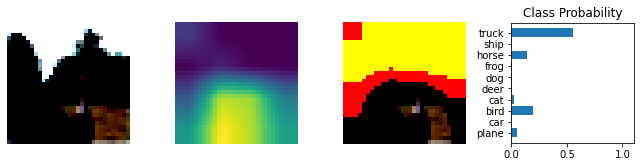

In [29]:
for i in range (10):
  view_classify (wrong[i][0], wrong[i][1], wrong[i][-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

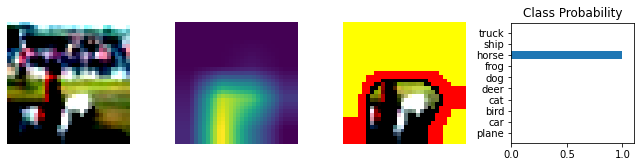

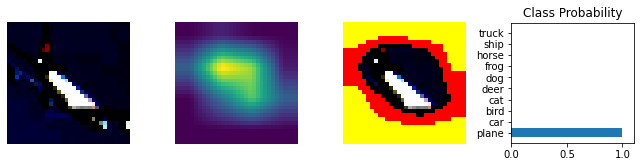

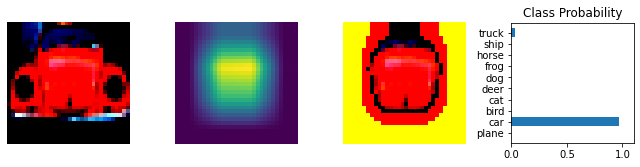

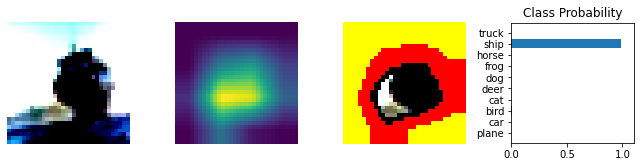

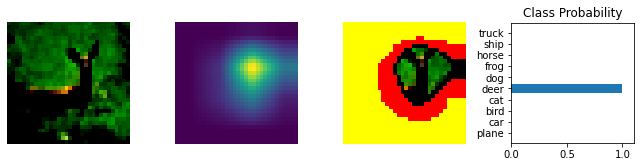

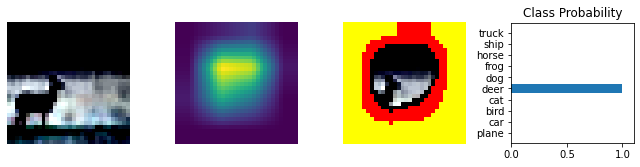

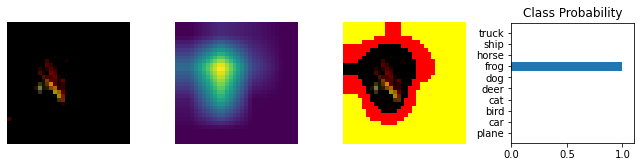

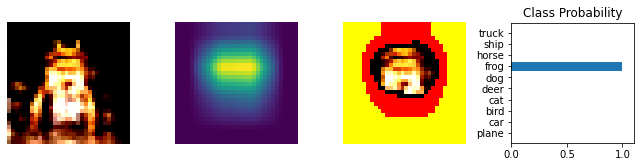

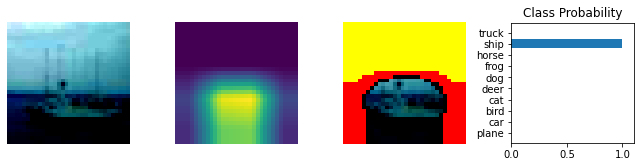

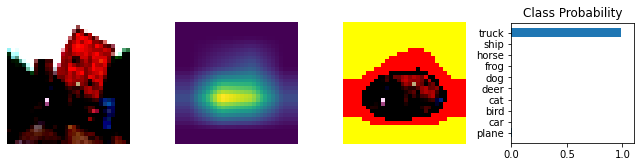

In [30]:
for i in range (10):
  view_classify (correct[i][0], correct[i][1], correct[i][-1])